This notebook is part of the Zero-Cost Deep-Learning to Enhance Microscopy project (https://github.com/HenriquesLab/DeepLearning_Collab/wiki). Jointly developed by the Jacquemet (link to https://cellmig.org/) and Henriques (https://henriqueslab.github.io/) laboratories.

This notebook is largely based on the paper: **U-Net: Convolutional Networks for Biomedical Image Segmentation** by *Olaf Ronneberger, Philipp Fischer, Thomas Brox*  (https://arxiv.org/abs/1505.04597)

And source code found in: https://github.com/zhixuhao/unet by *zhixuhao*

**Please also cite this original paper when using or developing this notebook.** 

# **How to use this notebook?**
---


**- Table of contents, Code snippets** and **Files**

On the left side of the notebook you find three tabs which contain from top to bottom the table of contents, code snippets and files

*Table of contents* = contains structure of the notebook. Click the content to move quickly between sections.

*Code snippets* = contain examples how to code certain tasks. You can ignore this when using this notebook.

*Files* = contain all available files. After mounting your google drive (see section 1.) you will find your files and folders here. 

**Remember that all uploaded files are purged after changing the runtime.** All files saved in Google Drive will remain. You do not need to use the Mount Drive-button; your Google Drive is connected in section 5.1.

**Note:** The "sample data" in "Files" contains default files. Do not upload anything here!

---
**- Text** and **Code Cells**

**Text cells** provide information and can be modified by douple-clicking the cell. You are currently reading the text cell. You can create a new text by clicking `+ Text`.

**Code cells** contain code and the code can be modfied by selecting the cell. To execute the cell, move your cursor on the `[ ]`-mark on the left side of the cell (play button appear). Click to execute the cell. After execution is done the animation of play button stops. You can create a new coding cell by clicking `+ Code`.

---
**- Making changes to the notebook**

**Please make a copy** of the notebook and save it to your Google Drive if you make changes. To do this click file -> save a copy in drive.

To edit a cell, double click on the text. This will show you either the source code (in code cells) or the source text (in text cells).
It is advisable to use the `#`-mark in code cells. This allows you to keep the original code piece in the cell as a comment.

**For example:**

*Original code:* all lines are excuted

`my_files = 2`

`my_mask = "names of masks"`

*Modified code:* the 1st line is not executed, but the 2nd and 3rd line are.

`#my_files = 2`

`my_files = 200`

# **U-Net**
---
####U-net is an encoder-decoder architecture originally used for image segmentation and published in 2015 by Ronneberger *et al.* in [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597). The first half of the U-net architecture is a downsampling convolutional neural network which acts as a feature extractor from input images. The other half upsamples these results and restores an image by combining results from downsampling with the upsampled images.

####Since its publication, U-net has become a commonly used architecture for image-to-image tasks and is also used in [CARE](https://www.nature.com/articles/s41592-018-0216-7).
####This notebook represents a basic U-net architecture which can be used by users to get acquainted with the functionality of image-to-image networks in microscopy. It should not be expected to provide results as good as networks built for specific image-to-image tasks.
####This script is inspired by the original U-net architecture and adapted from [this repository](https://github.com/zhixuhao/unet) 

(adapted for this notebook by Lucas von Chamier (Henriques Lab, MRC LMCB))

# **0. Before Getting Started with Unet**
---

####**Create folders in the following format and upload them into your google drive:**
*   **drive**
    - source
    - target
    - validation
    - validation-groundtruth

####The source and target folders should contain pairs of input-output images, the image transformation the U-net is trained to learn. 

####The test folder contains additional data which can be used to check if the model performs as desired. 

####The images in the test folder should be paired with paired images in the validation-groundtruth.

# **1. Install the U-net Dependencies**
---

In [0]:
#@markdown ###Play to install U-net dependencies
!pip install keras==2.2.5
!pip install data

  Created wheel for data: filename=data-0.4-cp36-none-any.whl size=7247 sha256=5ec61f8d196f8685a50ca82423179b33e7bc695c8449cda8da504bb489efaa7c
  Stored in directory: /root/.cache/pip/wheels/f6/09/e5/5afbc45fb0de471541092c7cd8b48d3483be68b1890955e6b9
Successfully built data


# **2. Mount Google Drive**
---

In [0]:
#@markdown ###Mount your Google Drive to the notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **3. Choosing Parameters**
---

**3.1 Image Parameters**
---
####**1. Select the dimensions of the input and output images:** If a value different from the current shape is chosen, the images will be reshaped for training. Using a different dimension for targets will also result in predictions with the same dimensions.

####**2. Select Colour Mode:** Which colour mode are the images to be displayed in? Tested only with grayscale. Using different colourmodes may require some other modifications.

####**3. Select file type:** This will affect the type of file the network puts out in its predictions after training and does not affect performance.

In [0]:
from keras import models
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as keras
from data import *
from __future__ import print_function
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
from skimage import img_as_ubyte

#@markdown ##Image parameters

input_image_size =  1024#@param {type:"number"}
output_image_size =  1024#@param {type:"number"}
input_colour_mode = 'grayscale' #@param ["grayscale", "rgb", "rgba"]
target_colour_mode = 'grayscale' #@param ["grayscale" , "rgb" , "rgba"]
prediction_format = '.tif' #@param [".tif",".png"]

#Here we normalize the input images and adjust the values of the mask to clearly demarcate signal from background.
def adjustData(img,mask,flag_multi_class,num_class):
    img = img / 255
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)


def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (output_image_size,output_image_size),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

def testGenerator(test_path,target_size = (output_image_size,output_image_size),flag_multi_class = False,as_gray = True):
    for filename in os.listdir(test_path):
        img = io.imread(os.path.join(test_path,filename),as_gray = as_gray)
        img = img/255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        io.imsave(os.path.join(save_path,"predicted_"+str(i)+prediction_format),img_as_ubyte(item))

**3.2 Network Hyperparameters**
---
####**1. Choosing Pooling Steps:** Choosing a different number of pooling layers can affect the performance of the network. Each additional pooling step will also two additional convolutions. The network can learn more complex information but is also more likely to overfit. Achieving best performance may require testing different values here.

####**2. Choosing a Loss Function:** Training performance depends strongly on the loss function. To find out more about losses, see: https://keras.io/losses/.

####**3. Steps per epoch:** This number should be equivalent to the number of samples in the training set divided by the batch size, to ensure the training iterates through the entire training set. Smaller values can be tested for testing.

####**4. Epochs:** Choose more epochs for larger training sets. Observing how much the loss reduces between epochs during training may help determine the optimal value.

In [0]:
pooling_steps = 3 #@param [1,2,3,4]{type:"raw"}
loss_function = 'mean_squared_error' #@param ["binary_crossentropy", "mean_squared_error", "mean_absolute_error"] {type:"string"}
batch_size =  3#@param {type:"integer"}
steps_per_epoch =  100#@param {type:"number"}
epochs =  30#@param {type:"number"}

#This is code outlines the architecture of U-net. The choice of pooling steps decides the depth of the network. 
def unet(pretrained_weights = None,input_size = (input_image_size,input_image_size,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
#Downsampling steps
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    
    if pooling_steps > 1:
      pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
      conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
      conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

      if pooling_steps > 2:
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
      
        if pooling_steps > 3:
          pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
          conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
          conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
          drop5 = Dropout(0.5)(conv5)

#Upsampling steps

          up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
          merge6 = concatenate([drop4,up6], axis = 3)
          conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
          conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
          
    if pooling_steps > 2:
      up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
      if pooling_steps > 3:
        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
      merge7 = concatenate([conv3,up7], axis = 3)
      conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
      
    if pooling_steps > 1:
      up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv3))
      if pooling_steps > 2:
        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
      merge8 = concatenate([conv2,up8], axis = 3)
      conv8 = Conv2D(128, 3, activation= 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    
    if pooling_steps == 1:
      up9 = Conv2D(64, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
    else:
      up9 = Conv2D(64, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8)) #activation = 'relu'
    
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(merge9) #activation = 'relu'

#You can add to or reduce the number of convolution layers, 
#but make sure the output dimensions of one layer match the input dimensions of the next.
    
    #conv9 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9) #activation = 'relu'
    #conv9 = Conv2D(2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9) #activation = 'relu'
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = loss_function, metrics = ['acc'])
    
    print(model.summary())

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

**3.3 Data Augmentation**
---
####Data augmentation can improve training progress by amplifying differences in the dataset. This can be useful if the available dataset is small as without augmentation a network could quickly learn every example in the dataset. Augmentation is not necessary for training and if the dataset is large the values can be set to 'None'.

In [0]:
#@markdown ##Augmentation Options
#@markdown **Shift images on the horizontal axis** (0.1 is equivalent to 10%):
width_shift_range =  0.1#@param {type:"number"}
#@markdown **Shift images on the vertical axis** (0.1 is equivalent to 10%):
height_shift_range =  0.1#@param {type:"number"}

#@markdown **Rotate image within angle range (degrees):**
rotation_range =  90#@param {type:"number"}
#@markdown **Enlargen fields of view of images:**
zoom_range =  0.2#@param {type:"number"}
#@markdown **Choose shearing range:**
shear_range =  0.2#@param {type:"number"}
#@markdown **Horizontal Flip:**
horizontal_flip = True #@param {type:"boolean"}
#@markdown **Vertical Flip:**
vertical_flip = False #@param {type:"boolean"}

#given behind the # are the default values for each parameter.

data_gen_args = dict(width_shift_range=width_shift_range,#0.1
                     height_shift_range=height_shift_range,#0.1
                     rotation_range=rotation_range, #90
                     zoom_range=zoom_range,
                     shear_range=shear_range,
                     horizontal_flip=horizontal_flip,
                     vertical_flip=vertical_flip,
                     fill_mode='nearest') #0.2)

# **4. Select Base, Source and Target Folders**
---

####The base directory is the directory where all your folders are located. If your source and target folders were uploaded directly into google drive the base folder should be: */content/drive/My Drive/*.
####If your files are nested deeper in your drive change the base directory accordingly. 

####The inputs_folder and targets_folder arguments should simply be the names of the respective folders containing your training files.

In [0]:
#@markdown ##Select the source and target folders

base_directory = '/content/drive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/StarDist' #@param {type:"string"}
inputs_folder = 'images' #@param {type:"string"}
targets_folder = 'masks' #@param {type:"string"}
model_name = 'my_model' #@param {type:"string"}
save_directory = '/content/' #@param {type:"string"}
Generator = trainGenerator(batch_size, base_directory, inputs_folder, targets_folder,data_gen_args,save_to_dir = None)
model = unet()

save_best_only = True #@param {type:"boolean"}
if save_best_only == True:
  model_checkpoint = ModelCheckpoint(save_directory+model_name+'.hdf5', monitor='loss',verbose=1, save_best_only=True)
else:
  model_checkpoint = ModelCheckpoint(save_directory+model_name+'.{epoch:02d}-{loss:.2f}.hdf5', monitor='loss', verbose=1, save_best_only=False)

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 1024, 1024, 1 0                                            
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 1024, 1024, 6 640         input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_123 (Conv2D)             (None, 1024, 1024, 6 36928       conv2d_122[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_23 (MaxPooling2D) (None, 512, 512, 64) 0           conv2d_123[0][0]                 
___________________________________________________________________________________________

# **5. Train U-net**
---
####**Troubleshooting:** If you receive a time-out or exhausted error, try reducing the batchsize of your training set. This reduces the amount of data loaded into the model at one point in time. 

In [0]:
#@markdown ##**Start Training**
model.fit_generator(Generator,steps_per_epoch=steps_per_epoch,epochs=epochs,callbacks=[model_checkpoint], shuffle=True)


Epoch 1/30
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
40/40 [==============================] - 48s 1s/step - loss: 0.0733 - acc: 0.9399

Epoch 00001: loss improved from inf to 0.07328, saving model to /content/my_model.hdf5
Epoch 2/30
40/40 [==============================] - 46s 1s/step - loss: 0.0546 - acc: 0.9451

Epoch 00002: loss improved from 0.07328 to 0.05460, saving model to /content/my_model.hdf5
Epoch 3/30
40/40 [==============================] - 45s 1s/step - loss: 0.0503 - acc: 0.9492

Epoch 00003: loss improved from 0.05460 to 0.05027, saving model to /content/my_model.hdf5
Epoch 4/30
40/40 [==============================] - 45s 1s/step - loss: 0.0541 - acc: 0.9453

Epoch 00004: loss did not improve from 0.05027
Epoch 5/30
40/40 [==============================] - 45s 1s/step - loss: 0.0541 - acc: 0.9452

Epoch 00005: loss did not improve from 0.05027
Epoch 6/30
40/40 [==============================] - 45s 1s/step - loss: 0.0525 - acc: 0

# **6. Prediction and Test**
---

####**Predict (from Validation source):** To use the network for predictions, choose the validation folder where you keep the files you want to use for inference.

####**Test (Validation targets):** To test whether the network achieves the desired performance, select a validation target folder with ground truth examples. By playing the below cell, the trained model will infer results from the validation files and a random sample will be picked and displayed side-by-side with the prediction and the ground truth from the target folder.

####**Saving Files:** Choose your preferred location for saving the predicted files. By default this will be the content folder which allows viewing the files instead of saving to drive. Change this to save to your drive folder.

###**Model:** Choose the name of the saved model that you want to use for the prediction of data.

####**Troubleshooting:** If there is a low contrast image warning when saving the images, this may be due to overfitting of the model to the data. It may result in images containing only a single colour. Train the network again with different network hyperparameters.

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 1024, 1024, 1 0                                            
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 1024, 1024, 6 640         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_101 (Conv2D)             (None, 1024, 1024, 6 36928       conv2d_100[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 512, 512, 64) 0           conv2d_101[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: /content/predicted_0.tif is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: /content/predicted_1.tif is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: /content/predicted_2.tif is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: /content/predicted_3.tif is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: /content/predicted_4.tif is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: /content/predicted_5.tif is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: /content/predicted_6.tif is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: /content/predicted_7.tif is a low

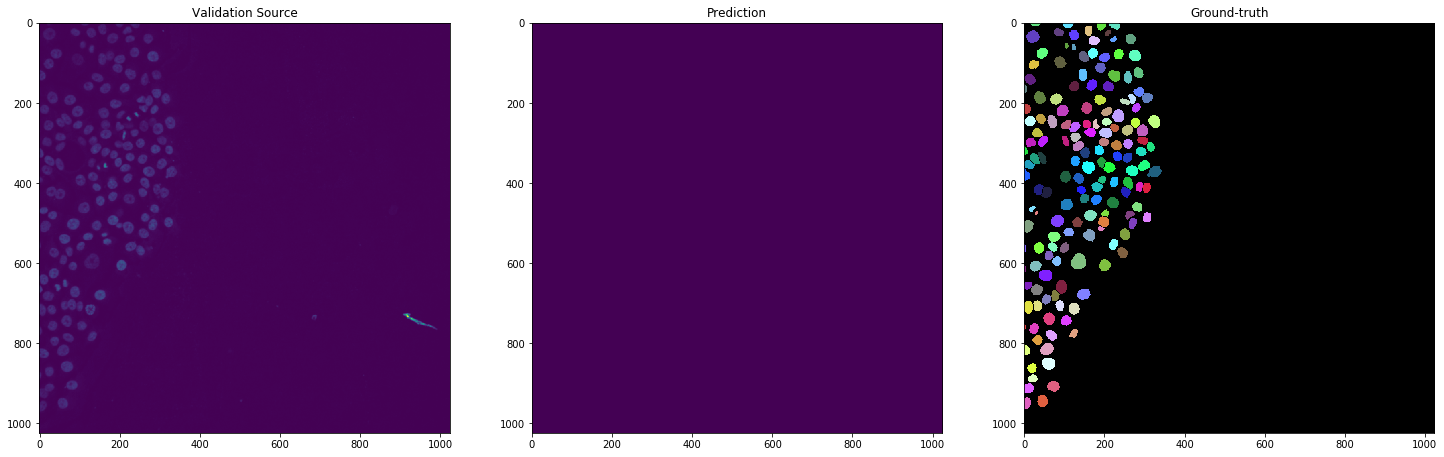

In [0]:
import matplotlib.pyplot as plt
import random
from PIL import Image

os.chdir('/content/')
Validation_source_folder = '/images' #@param {type:"string"}
Validation_target_folder = '/masks' #@param {type:"string"}
Save_folder = '/content/' #@param {type:"string"}
model_name = 'my_model' #@param {type:"string"}

testGen = testGenerator(base_directory+Validation_source_folder)
#load the trained model
model = unet()
model.load_weights(model_name+".hdf5")

#Create a list of validation sources
source_dir_list = os.listdir(base_directory+Validation_source_folder)
num = len(source_dir_list)

#Use the model to infer predictions from the validation sources
results = model.predict_generator(testGen, num, verbose=1)
saveResult(Save_folder,results)

#Fetch a random validation source and corresponding model prediction
os.chdir(base_directory+Validation_source_folder)
random_choice = random.randint(0,num)
random_sample = os.path.join(Validation_source_folder,source_dir_list[random_choice])
I = plt.imread(base_directory+random_sample)
os.chdir('/content/')
J = plt.imread('predicted_'+str(random_choice)+prediction_format)

#Fetch the corresponding validation target for inspection of prediction quality
os.chdir(base_directory+Validation_target_folder)
target_dir_list = os.listdir(base_directory + Validation_target_folder)
val = os.path.join(Validation_target_folder, target_dir_list[random_choice])
K = plt.imread(base_directory+val)

#Display validation source, prediction and target
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(25)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.title.set_text('Validation Source')
ax2.title.set_text('Prediction')
ax3.title.set_text('Ground-truth')
ax1.imshow(I)
ax2.imshow(J)
ax3.imshow(K)